In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [71]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [72]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential


In [73]:
# setting global variables
dbBase = r"top_100_txt"
all_sentences = []
all_labels = []

In [74]:
# reading the words from file and creating a dataset
types = ['Bearings', 'Bolts', 'Collets', 'Springs', 'Sprockets']
class_num = len(types)

for label, type in enumerate(types):

    with open(f"{dbBase}//{type}_100.txt", mode='r') as partFile:
        content = partFile.readlines()
        content = [c.replace("\n", "") for c in content]

        all_sentences.extend(content)
        all_labels.extend([label] * len(content))

all_sentences = np.array(all_sentences)
all_labels = np.array(all_labels)

# binarize the labels
le = LabelBinarizer()
all_labels = le.fit_transform(all_labels)

In [75]:
# do a trin test split
train_sentences, \
test_sentences, \
trainy, \
testy = train_test_split(all_sentences,
                         all_labels,
                         stratify=all_labels,
                         test_size=0.3,
                         random_state=42)

In [76]:
vocab_size = 374
embedding_dim = 16
max_length = 5
trunc_type = "post"
oov_tok = "<OOV>"

In [77]:
# tokenize the train set
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length,
                                       truncating=trunc_type)
# tokenise and pad the test set
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# check out the word index
print(len(tokenizer.word_index.keys()))
print(tokenizer.word_index)

374
{'<OOV>': 1, 'holder': 2, 'elastic': 3, 'screw': 4, 'gear': 5, 'workpiece': 6, 'roller': 7, 'centering': 8, 'element': 9, 'helical': 10, 'tool': 11, 'energy': 12, 'bearings': 13, 'force': 14, 'rod': 15, 'wheel': 16, 'clamping': 17, 'machine': 18, 'fastener': 19, 'gears': 20, 'threaded': 21, 'shafts': 22, 'harmonic': 23, 'coil': 24, 'chuck': 25, 'pinion': 26, 'member': 27, 'chain': 28, 'tension': 29, 'radial': 30, 'sleeve': 31, 'hex': 32, 'wrench': 33, 'shaft': 34, 'lever': 35, 'rear': 36, 'gripper': 37, 'self': 38, 'concentric': 39, 'squeezer': 40, 'speed': 41, 'holding': 42, 'hold': 43, 'spherical': 44, 'compression': 45, 'shifters': 46, 'gearbox': 47, 'torsion': 48, 'allen': 49, 'torsional': 50, 'torque': 51, 'dowel': 52, 'cnc': 53, 'fixture': 54, 'hydraulic': 55, 'brake': 56, 'springs': 57, 'component': 58, 'bolt': 59, 'axle': 60, 'conveyor': 61, 'tensioner': 62, 'driven': 63, 'jaw': 64, 'piston': 65, 'joiner': 66, 'fixer': 67, 'ball': 68, 'bevel': 69, 'spline': 70, 'taper': 71,

In [78]:
# now construct the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=class_num, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer = 'adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 5, 16)             5984      
_________________________________________________________________
flatten_5 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               10368     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 16,997
Trainable params: 16,997
Non-trainable params: 0
_________________________________________________________________


In [79]:
epoch_no = 30
H = model.fit(padded_train_sequences,
          trainy,
          epochs=epoch_no,
          validation_data=(padded_test_sequences, testy))

Train on 350 samples, validate on 150 samples
Epoch 1/30
350/350 [==============================] - 1s 3ms/sample - loss: 1.6091 - accuracy: 0.1971 - val_loss: 1.6044 - val_accuracy: 0.2600
Epoch 2/30
350/350 [==============================] - 0s 245us/sample - loss: 1.5948 - accuracy: 0.4657 - val_loss: 1.5978 - val_accuracy: 0.3000
Epoch 3/30
350/350 [==============================] - 0s 251us/sample - loss: 1.5779 - accuracy: 0.6143 - val_loss: 1.5865 - val_accuracy: 0.3867
Epoch 4/30
350/350 [==============================] - 0s 219us/sample - loss: 1.5492 - accuracy: 0.7171 - val_loss: 1.5671 - val_accuracy: 0.4533
Epoch 5/30
350/350 [==============================] - 0s 184us/sample - loss: 1.4985 - accuracy: 0.7914 - val_loss: 1.5341 - val_accuracy: 0.4667
Epoch 6/30
350/350 [==============================] - 

In [80]:
epochs = range(1,epoch_no+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

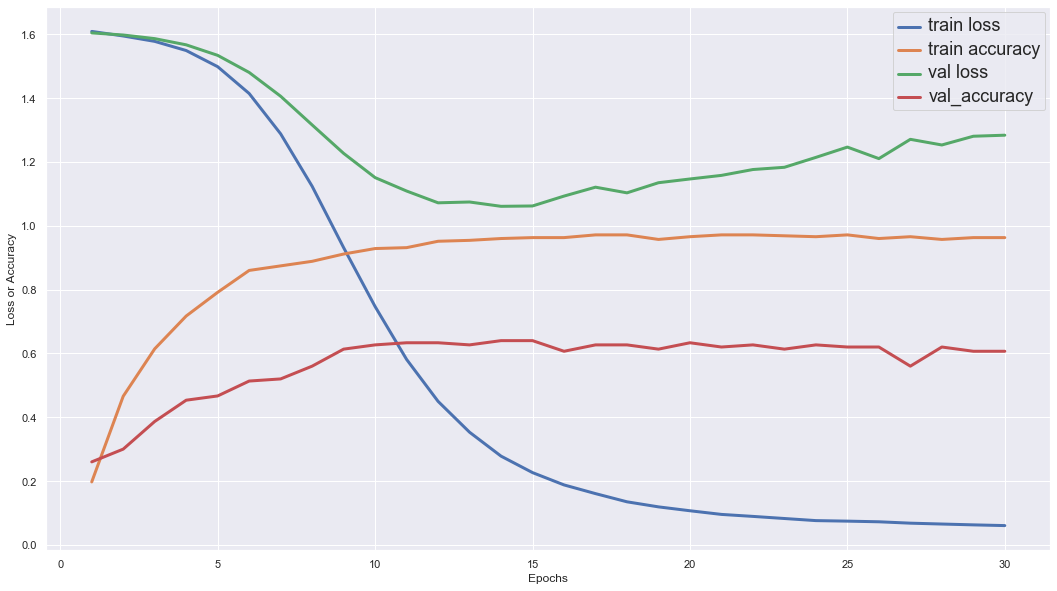

In [81]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [82]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(374, 16)


In [83]:
reverse_word_index = dict([(val, key) for (key, val) in tokenizer.word_index
                       .items()])

In [84]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()